In [ ]:
!pip install xlrd

In [ ]:
!pip install openpyxl

import pathlib

import pandas as pd
import numpy as np
import xlrd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import scipy.stats as stats
import tensorflow as tf

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install bayesian-optimization

In [ ]:
PY_DATOS_REALES_EST_SA=pd.read_excel("/content/drive/MyDrive/Datos/Copia de 4 Variables. Datos reales estandarizados sin atípicos (z-score).xlsx", sheet_name='Datos sin atipicos', header=0, index_col=0, usecols='A, B, C, D, E')
PY_DATOS_REALES_EST_SA

,Días,Área,PY_VC_PCA,Valor_Proyecto
#,,,,
1,0.199969,-0.224328,-0.670771,-0.563421
2,0.199969,-0.224328,-0.670771,-0.545120
3,0.199969,-0.222966,-0.670771,-0.544601
4,0.199969,-0.222966,-0.670771,-0.532932
5,1.478731,-0.182279,-0.670771,-0.532623
...,...,...,...,...
121,-0.699160,-0.219754,-1.883419,-0.617652
122,-0.659199,-0.223679,-1.883419,-0.604545
123,-0.579276,-0.224410,-1.883419,-0.584883


In [ ]:
PY_DATOS_REALES_EST_SA.describe()

,Días,Área,PY_VC_PCA,Valor_Proyecto
count,115.000000,115.000000,115.000000,115.000000
mean,-0.082193,-0.098454,-0.089025,-0.097465
std,0.780387,0.605987,1.861373,0.706249
min,-0.918948,-0.224417,-1.932311,-0.682176
25%,-0.669189,-0.224096,-1.883419,-0.587202
50%,-0.359489,-0.222363,-0.670771,-0.410561
75%,0.219950,-0.203633,0.739387,0.150954
max,3.576699,4.300396,3.524117,2.571424


In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, ReLU, ELU, Activation
from keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad
from keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from bayes_opt import BayesianOptimization
from scipy.stats import spearmanr
import random

# Fijar la semilla para reproducibilidad
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Función personalizada para calcular SSE
def sse(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_true - y_pred))

# Función personalizada para calcular SAE
def sae(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true - y_pred))

# Función personalizada para calcular el coeficiente de determinación R^2
def r2_keras(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

# Función personalizada para calcular el coeficiente de correlación de Pearson
def pearson_correlation(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    x = y_true - tf.reduce_mean(y_true)
    y = y_pred - tf.reduce_mean(y_pred)
    r_num = tf.reduce_sum(x * y)
    r_den = tf.sqrt(tf.reduce_sum(tf.square(x)) * tf.reduce_sum(tf.square(y)))
    return r_num / (r_den + tf.keras.backend.epsilon())

# Función para calcular RMSE
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Seleccionar las columnas relevantes para la predicción de 'Valor_Proyecto'
data = PY_DATOS_REALES_EST_SA[['Días', 'Área', 'PY_VC_PCA', 'Valor_Proyecto']]
X = data.drop('Valor_Proyecto', axis=1).values
y = data['Valor_Proyecto'].values

# Dividir los datos en entrenamiento y validación con una semilla fija
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Función que entrena el modelo y devuelve la pérdida final, el historial y el modelo
def train_model_with_params(units_1, units_2, learning_rate):
    model = Sequential([
        Dense(int(units_1), input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('relu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(int(units_2), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('relu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(1, activation='linear')
    ])

    # Usar Huber como pérdida y agregar Huber Loss como métrica
    model.compile(optimizer=Adagrad(learning_rate),
                  loss=tf.keras.losses.Huber(), #----------------------------
                  metrics=['mae', 'mse', rmse, sse, sae, r2_keras, pearson_correlation, tf.keras.losses.Huber(name='huber_loss')])

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) #----------------50
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=1000,   #---------------1000
                        batch_size=64,
                        callbacks=[early_stopping, reduce_lr, checkpoint],
                        verbose=1)

    return -history.history['val_loss'][-1], history, model

# Función solo para la optimización bayesiana (retorna solo la pérdida)
def train_model_for_optimization(units_1, units_2, learning_rate):

    val_loss, _, _ = train_model_with_params(units_1, units_2, learning_rate)
    return val_loss

# Definir los límites para la optimización
pbounds = {
    'units_1': (5, 100),
    'units_2': (5, 100),
    'learning_rate': (0.0001, 0.1)
}

# Crear una instancia de BayesianOptimization con semilla
optimizer = BayesianOptimization(
    f=train_model_for_optimization,
    pbounds=pbounds,
    random_state=42,  # Fijar la semilla para la optimización bayesiana
    verbose=2
)

# Ejecutar la optimización
optimizer.maximize(init_points=2, n_iter=20) #---------------20

# Recuperar los mejores hiperparámetros
best_params = optimizer.max['params']

# Redondear los valores de las unidades a enteros para las capas
best_params['units_1'] = int(round(best_params['units_1']))
best_params['units_2'] = int(round(best_params['units_2']))

# Imprimir los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Entrenar el modelo con los mejores hiperparámetros encontrados y obtener el historial y el modelo
val_loss, history, model = train_model_with_params(
    best_params['units_1'],
    best_params['units_2'],
    best_params['learning_rate']
)

|   iter    |  target   | learni... |  units_1  |  units_2  |
-------------------------------------------------------------
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.6724 - loss: 0.7614 - mae: 1.0486 - mse: 2.0130 - pearson_correlation: 5.9929e-16 - r2_keras: -246.6328 - rmse: 1.3694 - sae: 4115.5127 - sse: 7681.2598
Epoch 1: val_loss improved from inf to 0.32601, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 570ms/step - huber_loss: 0.8477 - loss: 0.8682 - mae: 1.1692 - mse: 2.5215 - pearson_correlation: 5.4729e-16 - r2_keras: -292.8384 - rmse: 1.7143 - sae: 3209.6931 - sse: 6631.0806 - val_huber_loss: 0.2366 - val_loss: 0.3260 - val_mae: 0.6002 - val_mse: 0.5357 - val_pearson_correlation: 0.0000e+00 - val_r2_keras: -25.1031 - val_rmse: 0.8320 - val_sae: 368.6128 - val_sse: 366.1766 - learning_rate: 0.0375
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.3981 - loss: 0.4875 - mae: 0.7057 - mse: 1.0611 - pearson_correlation: -1.6205e-16 - r2_keras: -228.0875 - rmse: 1.3171 - sae: 3948.7158 - sse: 7106.0078
Epoch 2: val_loss did not improve from 0.32601
2/2 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.4918 - loss: 0.5157 - mae: 0.8187 - mse: 2.4936 - pearson_correlation: -1.6037e-16 - r2_keras: -464.6294 - rmse: 1.8778 - sae: 4336.9546 - sse: 14443.2402
Epoch 1: val_loss improved from inf to 0.28185, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 510ms/step - huber_loss: 0.4873 - loss: 0.5130 - mae: 0.8140 - mse: 2.3328 - pearson_correlation: -6.1236e-17 - r2_keras: -361.6673 - rmse: 1.7623 - sae: 3143.0461 - sse: 10241.6943 - val_huber_loss: 0.2580 - val_loss: 0.2818 - val_mae: 0.6336 - val_mse: 0.5404 - val_pearson_correlation: -2.1956e-16 - val_r2_keras: -32.2631 - val_rmse: 0.9392 - val_sae: 405.6927 - val_sse: 466.6182 - learning_rate: 0.0287
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - huber_loss: 0.2637 - loss: 0.2876 - mae: 0.4999 - mse: 1.1948 - pearson_correlation: 6.4248e-17 - r2_keras: -245.7217 - rmse: 1.3669 - sae: 3060.3274 - sse: 7653.0000
Epoch 2: val_loss improved from 0.28185 to 0.25562, sav

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 1.2987 - loss: 1.3183 - mae: 1.7687 - mse: 3.8672 - pearson_correlation: -3.7786e-16 - r2_keras: -575.7235 - rmse: 2.0899 - sae: 7495.9785 - sse: 17889.2422
Epoch 1: val_loss improved from inf to 0.31272, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - huber_loss: 1.2374 - loss: 1.2810 - mae: 1.7216 - mse: 3.7856 - pearson_correlation: -2.1380e-16 - r2_keras: -466.8908 - rmse: 2.0382 - sae: 5416.8413 - sse: 12904.5459 - val_huber_loss: 0.2931 - val_loss: 0.3127 - val_mae: 0.5716 - val_mse: 0.8274 - val_pearson_correlation: 6.0344e-17 - val_r2_keras: -30.3698 - val_rmse: 0.9121 - val_sae: 318.3019 - val_sse: 440.0596 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - huber_loss: 1.2939 - loss: 1.3135 - mae: 1.7637 - mse: 3.8481 - pearson_correlation: -1.8608e-16 - r2_keras: -573.1293 - rmse: 2.0851 - sae: 7477.8853 - sse: 17808.7734
Epoch 2: val_loss improved from 0.31272 to 0.29985

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.4966 - loss: 0.5222 - mae: 0.8432 - mse: 1.7815 - pearson_correlation: 3.3875e-16 - r2_keras: -275.0733 - rmse: 1.4459 - sae: 4092.2139 - sse: 8563.4473
Epoch 1: val_loss improved from inf to 0.26485, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step - huber_loss: 0.5314 - loss: 0.5434 - mae: 0.8821 - mse: 1.8305 - pearson_correlation: 2.5198e-16 - r2_keras: -246.8854 - rmse: 1.5282 - sae: 3037.7195 - sse: 6457.7700 - val_huber_loss: 0.2393 - val_loss: 0.2649 - val_mae: 0.5860 - val_mse: 0.5682 - val_pearson_correlation: 4.1573e-16 - val_r2_keras: -22.8799 - val_rmse: 0.7958 - val_sae: 332.0270 - val_sse: 334.9898 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.4943 - loss: 0.5199 - mae: 0.8391 - mse: 1.7752 - pearson_correlation: -1.0993e-16 - r2_keras: -273.9009 - rmse: 1.4428 - sae: 4077.1099 - sse: 8527.0830
Epoch 2: val_loss improved from 0.26485 to 0.26008, sav

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.9995 - loss: 1.0229 - mae: 1.4447 - mse: 3.2424 - pearson_correlation: 6.0995e-18 - r2_keras: -334.8939 - rmse: 1.5949 - sae: 5268.2295 - sse: 10419.0098
Epoch 1: val_loss improved from inf to 0.26177, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - huber_loss: 0.9775 - loss: 1.0095 - mae: 1.4372 - mse: 3.1008 - pearson_correlation: 8.7310e-17 - r2_keras: -262.0094 - rmse: 1.5047 - sae: 3797.8845 - sse: 7404.4180 - val_huber_loss: 0.2384 - val_loss: 0.2618 - val_mae: 0.5705 - val_mse: 0.5206 - val_pearson_correlation: 3.7816e-17 - val_r2_keras: -27.9620 - val_rmse: 0.8764 - val_sae: 345.4819 - val_sse: 406.2822 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - huber_loss: 0.9933 - loss: 1.0167 - mae: 1.4378 - mse: 3.2170 - pearson_correlation: -3.0547e-16 - r2_keras: -332.4679 - rmse: 1.5891 - sae: 5247.5371 - sse: 10343.7559
Epoch 2: val_loss did not improve from 0.26177
2/2 ━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 1.0416 - loss: 1.0655 - mae: 1.4925 - mse: 3.7014 - pearson_correlation: -4.1193e-16 - r2_keras: -619.3718 - rmse: 2.1675 - sae: 7307.8833 - sse: 19243.1582
Epoch 1: val_loss improved from inf to 0.36226, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - huber_loss: 1.0273 - loss: 1.0569 - mae: 1.4845 - mse: 3.5057 - pearson_correlation: -4.7759e-16 - r2_keras: -458.0330 - rmse: 1.9211 - sae: 5191.2681 - sse: 13361.9229 - val_huber_loss: 0.3374 - val_loss: 0.3623 - val_mae: 0.7419 - val_mse: 0.8260 - val_pearson_correlation: 6.0180e-16 - val_r2_keras: -23.9157 - val_rmse: 0.8128 - val_sae: 349.0514 - val_sse: 349.5207 - learning_rate: 0.1000
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.3606 - loss: 0.3855 - mae: 0.7639 - mse: 0.8524 - pearson_correlation: 6.3226e-16 - r2_keras: -102.8079 - rmse: 0.8866 - sae: 2946.5183 - sse: 3219.9912
Epoch 2: val_loss improved from 0.36226 to 0.26981, savi

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.6457 - loss: 0.6725 - mae: 1.1192 - mse: 1.6020 - pearson_correlation: 7.0349e-16 - r2_keras: -176.5731 - rmse: 1.1596 - sae: 4061.7271 - sse: 5508.0942
Epoch 1: val_loss improved from inf to 0.45028, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - huber_loss: 0.5900 - loss: 0.6386 - mae: 1.0749 - mse: 1.5114 - pearson_correlation: 2.7422e-16 - r2_keras: -144.9593 - rmse: 1.1439 - sae: 2954.5540 - sse: 3995.5452 - val_huber_loss: 0.4235 - val_loss: 0.4503 - val_mae: 0.8358 - val_mse: 1.1444 - val_pearson_correlation: -4.2032e-17 - val_r2_keras: -31.0897 - val_rmse: 0.9225 - val_sae: 378.0544 - val_sse: 450.1581 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.6414 - loss: 0.6682 - mae: 1.1146 - mse: 1.5890 - pearson_correlation: 2.0805e-16 - r2_keras: -175.3654 - rmse: 1.1557 - sae: 4047.2993 - sse: 5470.6357
Epoch 2: val_loss did not improve from 0.45028
2/2 ━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 1.1422 - loss: 1.2334 - mae: 1.5702 - mse: 3.9510 - pearson_correlation: 6.6348e-16 - r2_keras: -436.6549 - rmse: 1.8205 - sae: 5995.5005 - sse: 13575.5088
Epoch 1: val_loss improved from inf to 0.59976, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 478ms/step - huber_loss: 1.5285 - loss: 1.4688 - mae: 1.8191 - mse: 5.1571 - pearson_correlation: 4.0385e-16 - r2_keras: -511.5649 - rmse: 2.2630 - sae: 4730.8696 - sse: 11640.2715 - val_huber_loss: 0.5066 - val_loss: 0.5998 - val_mae: 0.9168 - val_mse: 1.1883 - val_pearson_correlation: 4.8251e-16 - val_r2_keras: -34.2240 - val_rmse: 0.9665 - val_sae: 424.6720 - val_sse: 494.1266 - learning_rate: 0.0742
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 1.2224 - loss: 1.3155 - mae: 1.6581 - mse: 4.0003 - pearson_correlation: -2.5411e-16 - r2_keras: -461.5617 - rmse: 1.8716 - sae: 6400.5610 - sse: 14348.0850
Epoch 2: val_loss improved from 0.59976 to 0.46424, savi

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.6388 - loss: 0.7285 - mae: 1.0045 - mse: 1.6677 - pearson_correlation: 1.8309e-16 - r2_keras: -198.8639 - rmse: 1.2303 - sae: 4025.0500 - sse: 6199.5278
Epoch 1: val_loss improved from inf to 0.37486, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step - huber_loss: 1.0017 - loss: 0.9494 - mae: 1.2493 - mse: 2.6553 - pearson_correlation: 1.1347e-16 - r2_keras: -323.0701 - rmse: 1.7957 - sae: 3330.0107 - sse: 6371.4316 - val_huber_loss: 0.2845 - val_loss: 0.3749 - val_mae: 0.6705 - val_mse: 0.6554 - val_pearson_correlation: -1.6270e-17 - val_r2_keras: -24.3630 - val_rmse: 0.8201 - val_sae: 351.0662 - val_sse: 355.7952 - learning_rate: 0.0361
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - huber_loss: 0.3851 - loss: 0.4755 - mae: 0.6960 - mse: 1.0059 - pearson_correlation: 1.9635e-16 - r2_keras: -177.4165 - rmse: 1.1624 - sae: 3641.3533 - sse: 5534.2578
Epoch 2: val_loss improved from 0.37486 to 0.32772, saving 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.5521 - loss: 0.6424 - mae: 0.9856 - mse: 1.2426 - pearson_correlation: 5.3218e-17 - r2_keras: -181.4510 - rmse: 1.1755 - sae: 4015.1421 - sse: 5659.4028
Epoch 1: val_loss improved from inf to 0.36958, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - huber_loss: 1.4839 - loss: 1.2102 - mae: 1.5558 - mse: 5.8086 - pearson_correlation: -2.1446e-17 - r2_keras: -708.0675 - rmse: 2.4953 - sae: 3728.1599 - sse: 10663.5498 - val_huber_loss: 0.2755 - val_loss: 0.3696 - val_mae: 0.5391 - val_mse: 0.7537 - val_pearson_correlation: -4.8727e-16 - val_r2_keras: -28.3674 - val_rmse: 0.8825 - val_sae: 290.5088 - val_sse: 411.9687 - learning_rate: 0.1000
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - huber_loss: 0.9331 - loss: 1.0272 - mae: 1.3211 - mse: 2.6231 - pearson_correlation: 2.1482e-16 - r2_keras: -277.9808 - rmse: 1.4535 - sae: 4772.0674 - sse: 8653.6348
Epoch 2: val_loss did not improve from 0.36958
2/2 ━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 1.0368 - loss: 1.1253 - mae: 1.4859 - mse: 3.3118 - pearson_correlation: 2.7454e-16 - r2_keras: -333.9092 - rmse: 1.5926 - sae: 5318.4136 - sse: 10388.4658
Epoch 1: val_loss improved from inf to 0.42485, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - huber_loss: 1.0048 - loss: 1.1058 - mae: 1.4554 - mse: 3.3768 - pearson_correlation: 1.6795e-16 - r2_keras: -290.5656 - rmse: 1.6453 - sae: 3898.7556 - sse: 7726.7207 - val_huber_loss: 0.3364 - val_loss: 0.4249 - val_mae: 0.6917 - val_mse: 0.8987 - val_pearson_correlation: -2.3034e-16 - val_r2_keras: -25.1227 - val_rmse: 0.8323 - val_sae: 314.2090 - val_sse: 366.4518 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - huber_loss: 1.0198 - loss: 1.1083 - mae: 1.4655 - mse: 3.2416 - pearson_correlation: -7.0972e-16 - r2_keras: -326.9871 - rmse: 1.5760 - sae: 5252.5327 - sse: 10173.7480
Epoch 2: val_loss did not improve from 0.42485
2/2 ━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.5163 - loss: 0.6053 - mae: 0.9157 - mse: 1.2946 - pearson_correlation: -4.2725e-16 - r2_keras: -235.7180 - rmse: 1.3389 - sae: 4113.4043 - sse: 7342.6973
Epoch 1: val_loss improved from inf to 0.44911, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 481ms/step - huber_loss: 0.4964 - loss: 0.5933 - mae: 0.9067 - mse: 1.2465 - pearson_correlation: -3.5765e-16 - r2_keras: -191.5764 - rmse: 1.3090 - sae: 2994.8174 - sse: 5302.9185 - val_huber_loss: 0.3601 - val_loss: 0.4491 - val_mae: 0.7341 - val_mse: 0.9472 - val_pearson_correlation: -2.9263e-16 - val_r2_keras: -30.0451 - val_rmse: 0.9073 - val_sae: 346.8300 - val_sse: 435.5037 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.4931 - loss: 0.5821 - mae: 0.8910 - mse: 1.2271 - pearson_correlation: -7.5714e-16 - r2_keras: -226.8727 - rmse: 1.3136 - sae: 4039.1243 - sse: 7068.3247
Epoch 2: val_loss did not improve from 0.44911
2/2 ━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.7855 - loss: 0.8759 - mae: 1.1651 - mse: 2.1973 - pearson_correlation: -3.8766e-16 - r2_keras: -260.8495 - rmse: 1.4082 - sae: 4657.0342 - sse: 8122.2456
Epoch 1: val_loss improved from inf to 0.55706, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - huber_loss: 1.6901 - loss: 1.4271 - mae: 1.7372 - mse: 6.3198 - pearson_correlation: -3.7092e-16 - r2_keras: -694.7977 - rmse: 2.5511 - sae: 4181.8623 - sse: 11528.8916 - val_huber_loss: 0.4625 - val_loss: 0.5571 - val_mae: 0.8433 - val_mse: 1.0900 - val_pearson_correlation: -8.8774e-17 - val_r2_keras: -30.0064 - val_rmse: 0.9068 - val_sae: 376.2773 - val_sse: 434.9612 - learning_rate: 0.1000
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 1.3465 - loss: 1.4410 - mae: 1.8128 - mse: 4.3036 - pearson_correlation: -1.0178e-16 - r2_keras: -549.2463 - rmse: 2.0413 - sae: 7299.7676 - sse: 17067.9531
Epoch 2: val_loss improved from 0.55706 to 0.42204, sa

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.8210 - loss: 0.9112 - mae: 1.2861 - mse: 2.2590 - pearson_correlation: -6.9747e-17 - r2_keras: -312.3226 - rmse: 1.5404 - sae: 5531.3838 - sse: 9718.8760
Epoch 1: val_loss improved from inf to 0.35106, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step - huber_loss: 0.7764 - loss: 0.8841 - mae: 1.2454 - mse: 2.1572 - pearson_correlation: -1.0074e-16 - r2_keras: -257.1395 - rmse: 1.5226 - sae: 4010.2883 - sse: 7057.0454 - val_huber_loss: 0.2608 - val_loss: 0.3511 - val_mae: 0.5913 - val_mse: 0.6721 - val_pearson_correlation: -3.1019e-16 - val_r2_keras: -22.5022 - val_rmse: 0.7895 - val_sae: 301.2440 - val_sse: 329.6909 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.7915 - loss: 0.8817 - mae: 1.2534 - mse: 2.1736 - pearson_correlation: 3.5001e-17 - r2_keras: -300.2050 - rmse: 1.5103 - sae: 5405.2178 - sse: 9343.0010
Epoch 2: val_loss improved from 0.35106 to 0.34056, s

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.9303 - loss: 1.0157 - mae: 1.3623 - mse: 3.5463 - pearson_correlation: -5.5525e-17 - r2_keras: -416.8046 - rmse: 1.7788 - sae: 4905.6543 - sse: 12959.7754
Epoch 1: val_loss improved from inf to 0.35684, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 507ms/step - huber_loss: 1.0183 - loss: 1.0693 - mae: 1.4235 - mse: 3.7684 - pearson_correlation: -2.6176e-17 - r2_keras: -366.0518 - rmse: 1.8503 - sae: 3644.3870 - sse: 9678.1396 - val_huber_loss: 0.2715 - val_loss: 0.3568 - val_mae: 0.5856 - val_mse: 0.7004 - val_pearson_correlation: -1.7080e-16 - val_r2_keras: -23.5206 - val_rmse: 0.8064 - val_sae: 289.3486 - val_sse: 343.9778 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.9016 - loss: 0.9870 - mae: 1.3289 - mse: 3.4357 - pearson_correlation: -2.2363e-16 - r2_keras: -405.7541 - rmse: 1.7551 - sae: 4797.3896 - sse: 12617.0020
Epoch 2: val_loss did not improve from 0.35684
2/2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - huber_loss: 0.9518 - loss: 1.0410 - mae: 1.4275 - mse: 2.5172 - pearson_correlation: -3.1239e-16 - r2_keras: -251.4478 - rmse: 1.3827 - sae: 4839.6987 - sse: 7830.6152
Epoch 1: val_loss improved from inf to 0.50312, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - huber_loss: 2.0533 - loss: 1.7123 - mae: 2.0994 - mse: 8.1717 - pearson_correlation: -8.8941e-17 - r2_keras: -913.7894 - rmse: 2.8513 - sae: 4525.2168 - sse: 13976.7725 - val_huber_loss: 0.4084 - val_loss: 0.5031 - val_mae: 0.8289 - val_mse: 0.9031 - val_pearson_correlation: 5.9708e-16 - val_r2_keras: -32.2005 - val_rmse: 0.9383 - val_sae: 421.1376 - val_sse: 465.7402 - learning_rate: 0.1000
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - huber_loss: 0.7263 - loss: 0.8210 - mae: 1.0921 - mse: 2.8898 - pearson_correlation: 2.0493e-16 - r2_keras: -492.5926 - rmse: 1.9334 - sae: 5360.8926 - sse: 15310.6240
Epoch 2: val_loss did not improve from 0.50312
2/2 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.7383 - loss: 0.7624 - mae: 1.1148 - mse: 2.5884 - pearson_correlation: 3.4298e-16 - r2_keras: -429.2280 - rmse: 1.8050 - sae: 5584.8940 - sse: 13345.1357
Epoch 1: val_loss improved from inf to 0.19408, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 468ms/step - huber_loss: 0.7092 - loss: 0.7448 - mae: 1.1073 - mse: 2.4075 - pearson_correlation: 2.4160e-16 - r2_keras: -319.3269 - rmse: 1.6121 - sae: 3974.6895 - sse: 9289.8105 - val_huber_loss: 0.1694 - val_loss: 0.1941 - val_mae: 0.4349 - val_mse: 0.4048 - val_pearson_correlation: -1.0784e-16 - val_r2_keras: -25.1896 - val_rmse: 0.8334 - val_sae: 320.6740 - val_sse: 367.3901 - learning_rate: 0.1000
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - huber_loss: 0.4667 - loss: 0.4914 - mae: 0.8111 - mse: 1.2282 - pearson_correlation: 1.7448e-16 - r2_keras: -223.4874 - rmse: 1.3039 - sae: 4009.0979 - sse: 6963.3193
Epoch 2: val_loss did not improve from 0.19408
2/2 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 1.4520 - loss: 1.5422 - mae: 1.8967 - mse: 6.4509 - pearson_correlation: -7.6874e-17 - r2_keras: -824.6533 - rmse: 2.5005 - sae: 7657.3184 - sse: 25610.7324
Epoch 1: val_loss improved from inf to 0.34639, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 472ms/step - huber_loss: 1.7617 - loss: 1.7314 - mae: 2.0930 - mse: 7.1744 - pearson_correlation: -1.7427e-19 - r2_keras: -810.0500 - rmse: 2.8071 - sae: 5895.7197 - sse: 20130.8379 - val_huber_loss: 0.2518 - val_loss: 0.3464 - val_mae: 0.5798 - val_mse: 0.6161 - val_pearson_correlation: -3.8516e-17 - val_r2_keras: -23.2601 - val_rmse: 0.8021 - val_sae: 309.8691 - val_sse: 340.3232 - learning_rate: 0.1000
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.2141 - loss: 0.3087 - mae: 0.5179 - mse: 0.4642 - pearson_correlation: -3.5752e-16 - r2_keras: -132.1797 - rmse: 1.0043 - sae: 3151.7595 - sse: 4131.0693
Epoch 2: val_loss did not improve from 0.34639
2/2 ━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.5179 - loss: 0.6113 - mae: 0.9111 - mse: 1.3314 - pearson_correlation: 1.2799e-16 - r2_keras: -137.6773 - rmse: 1.0248 - sae: 3342.7634 - sse: 4301.5952
Epoch 1: val_loss improved from inf to 0.79762, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - huber_loss: 1.5372 - loss: 1.2322 - mae: 1.5476 - mse: 6.1422 - pearson_correlation: 2.1116e-16 - r2_keras: -732.1557 - rmse: 2.4707 - sae: 3368.9651 - sse: 10383.2119 - val_huber_loss: 0.6998 - val_loss: 0.7976 - val_mae: 1.1661 - val_mse: 1.8345 - val_pearson_correlation: 2.0248e-16 - val_r2_keras: -54.4967 - val_rmse: 1.2131 - val_sae: 528.5937 - val_sse: 778.5137 - learning_rate: 0.1000
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - huber_loss: 1.4343 - loss: 1.5321 - mae: 1.9106 - mse: 5.7095 - pearson_correlation: 1.9454e-16 - r2_keras: -694.7980 - rmse: 2.2955 - sae: 7329.4453 - sse: 21582.7852
Epoch 2: val_loss improved from 0.79762 to 0.54577, saving

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.2948 - loss: 0.3866 - mae: 0.6522 - mse: 0.6417 - pearson_correlation: -1.7495e-16 - r2_keras: -115.6207 - rmse: 0.9398 - sae: 3081.3701 - sse: 3617.4297
Epoch 1: val_loss improved from inf to 0.38993, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 494ms/step - huber_loss: 0.2943 - loss: 0.3864 - mae: 0.6441 - mse: 0.6503 - pearson_correlation: -6.8887e-17 - r2_keras: -97.9911 - rmse: 0.9520 - sae: 2246.5483 - sse: 2660.8123 - val_huber_loss: 0.2980 - val_loss: 0.3899 - val_mae: 0.6789 - val_mse: 0.7167 - val_pearson_correlation: 3.4505e-16 - val_r2_keras: -24.1349 - val_rmse: 0.8164 - val_sae: 350.6774 - val_sse: 352.5949 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.2874 - loss: 0.3793 - mae: 0.6417 - mse: 0.6247 - pearson_correlation: -2.1129e-16 - r2_keras: -114.1054 - rmse: 0.9336 - sae: 3058.3149 - sse: 3570.4241
Epoch 2: val_loss did not improve from 0.38993
2/2 ━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 1.1367 - loss: 1.2283 - mae: 1.6027 - mse: 3.3633 - pearson_correlation: -4.6182e-17 - r2_keras: -320.4436 - rmse: 1.5602 - sae: 5401.1152 - sse: 9970.7793
Epoch 1: val_loss improved from inf to 0.54228, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 471ms/step - huber_loss: 2.0911 - loss: 1.8100 - mae: 2.1901 - mse: 8.1092 - pearson_correlation: 7.3120e-17 - r2_keras: -859.5211 - rmse: 2.8354 - sae: 4836.2236 - sse: 14227.4307 - val_huber_loss: 0.4448 - val_loss: 0.5423 - val_mae: 0.8651 - val_mse: 1.0860 - val_pearson_correlation: 2.6813e-16 - val_r2_keras: -29.7624 - val_rmse: 0.9032 - val_sae: 369.4499 - val_sse: 431.5388 - learning_rate: 0.1000
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.6109 - loss: 0.7084 - mae: 1.0352 - mse: 1.4507 - pearson_correlation: -1.5297e-16 - r2_keras: -174.8278 - rmse: 1.1539 - sae: 3905.1919 - sse: 5453.9570
Epoch 2: val_loss improved from 0.54228 to 0.34948, savin

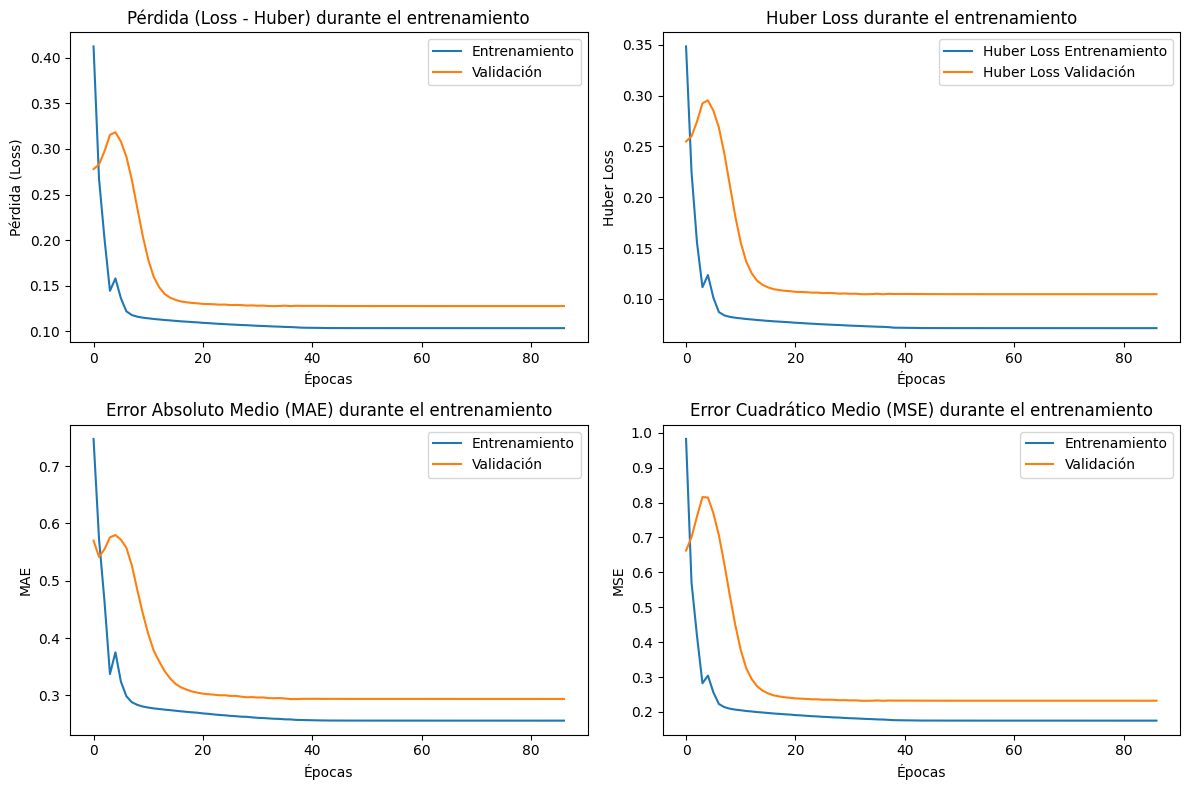

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


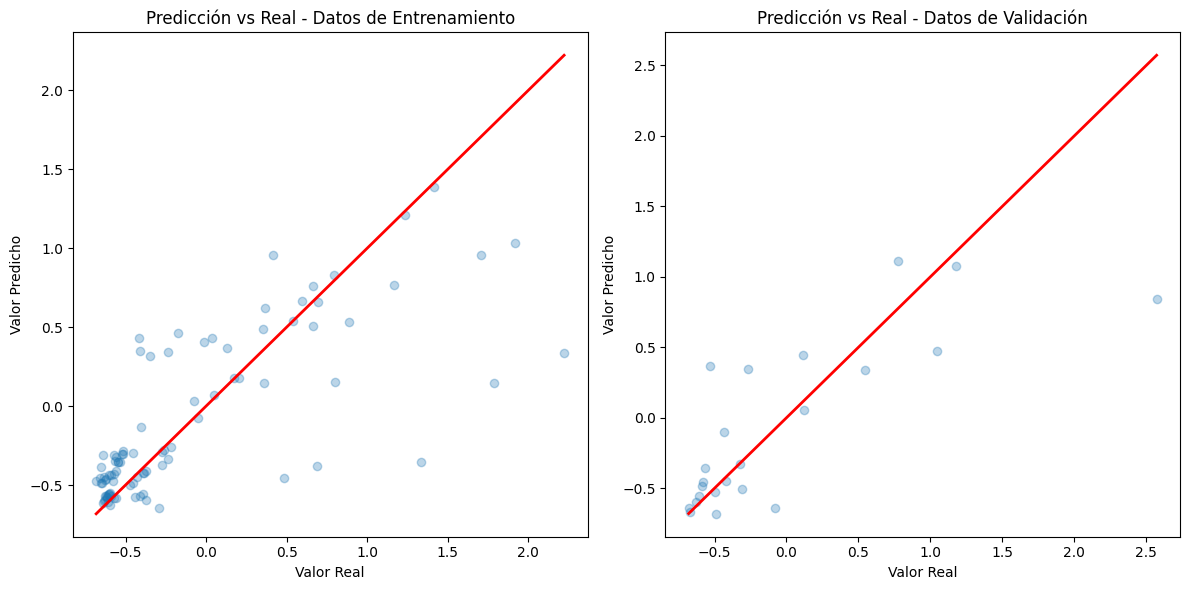


Métricas de entrenamiento:
MSE: 0.1937456658429946
RMSE: 0.4401654982424163
MAE: 0.25587258746379
R^2: 0.5833988275134265
Correlación de Pearson: -5.325510724851005e-16
Correlación de Spearman: 0.7636353828820924
SSE: 6125.120895662251
SAE: 5219.971268167099
Media del error: 0.012022126337275871
Desviación estándar del error: 0.8506014760655716
Huber Loss (Entrenamiento): 0.07113391160964966

Métricas de validación:
MSE: 0.23189784172164982
RMSE: 0.4815577241843908
MAE: 0.2935070658695597
R^2: 0.6197883000318056
Correlación de Pearson: -1.0789535527280803e-16
Correlación de Spearman: 0.7460474308300395
SSE: 496.657710711944
SAE: 368.5827803811733
Media del error: 0.02796332882857696
Desviación estándar del error: 0.9685450475652716
Huber Loss (Validación): 0.10456636548042297
El punto de convergencia (mejor epoch): 37


In [9]:
# Graficar las curvas de aprendizaje (entrenamiento y validación)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss - Huber) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['huber_loss'], label='Huber Loss Entrenamiento')
plt.plot(history.history['val_huber_loss'], label='Huber Loss Validación')
plt.title('Huber Loss durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Huber Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Validación')
plt.title('Error Absoluto Medio (MAE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['mse'], label='Entrenamiento')
plt.plot(history.history['val_mse'], label='Validación')
plt.title('Error Cuadrático Medio (MSE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar los datos entrenados vs reales y validados vs reales
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

plt.figure(figsize=(12, 6))

# Gráfico de datos de entrenamiento
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', lw=2)
plt.title('Predicción vs Real - Datos de Entrenamiento')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

# Gráfico de datos de validación
plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r', lw=2)
plt.title('Predicción vs Real - Datos de Validación')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.tight_layout()
plt.show()

# Función para calcular la media y desviación estándar
def calcular_media_desviacion(y_true, y_pred):
    diferencia = y_true - y_pred
    media = np.mean(diferencia)
    desviacion = np.std(diferencia)
    return media, desviacion

# Evaluar el modelo final en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)
pearson_train = pearson_correlation(y_train, y_train_pred).numpy()
spearman_train, _ = spearmanr(y_train, y_train_pred)  # Correlación de Spearman
sse_train = np.sum((y_train - y_train_pred) ** 2)
sae_train = np.sum(np.abs(y_train - y_train_pred))
media_train, desviacion_train = calcular_media_desviacion(y_train, y_train_pred)
huber_loss_train = history.history['huber_loss'][-1]

print("\nMétricas de entrenamiento:")
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"MAE: {mae_train}")
print(f"R^2: {r2_train}")
print(f"Correlación de Pearson: {pearson_train}")
print(f"Correlación de Spearman: {spearman_train}")
print(f"SSE: {sse_train}")
print(f"SAE: {sae_train}")
print(f"Media del error: {media_train}")
print(f"Desviación estándar del error: {desviacion_train}")
print(f"Huber Loss (Entrenamiento): {huber_loss_train}")

# Evaluar el modelo final en el conjunto de validación
mse_val = mean_squared_error(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)
pearson_val = pearson_correlation(y_val, y_val_pred).numpy()
spearman_val, _ = spearmanr(y_val, y_val_pred)  # Correlación de Spearman
sse_val = np.sum((y_val - y_val_pred) ** 2)
sae_val = np.sum(np.abs(y_val - y_val_pred))
media_val, desviacion_val = calcular_media_desviacion(y_val, y_val_pred)
huber_loss_val = history.history['val_huber_loss'][-1]

print("\nMétricas de validación:")
print(f"MSE: {mse_val}")
print(f"RMSE: {rmse_val}")
print(f"MAE: {mae_val}")
print(f"R^2: {r2_val}")
print(f"Correlación de Pearson: {pearson_val}")
print(f"Correlación de Spearman: {spearman_val}")
print(f"SSE: {sse_val}")
print(f"SAE: {sae_val}")
print(f"Media del error: {media_val}")
print(f"Desviación estándar del error: {desviacion_val}")
print(f"Huber Loss (Validación): {huber_loss_val}")

# Imprimir la época en la que se alcanzó la mejor validación
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"El punto de convergencia (mejor epoch): {best_epoch}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


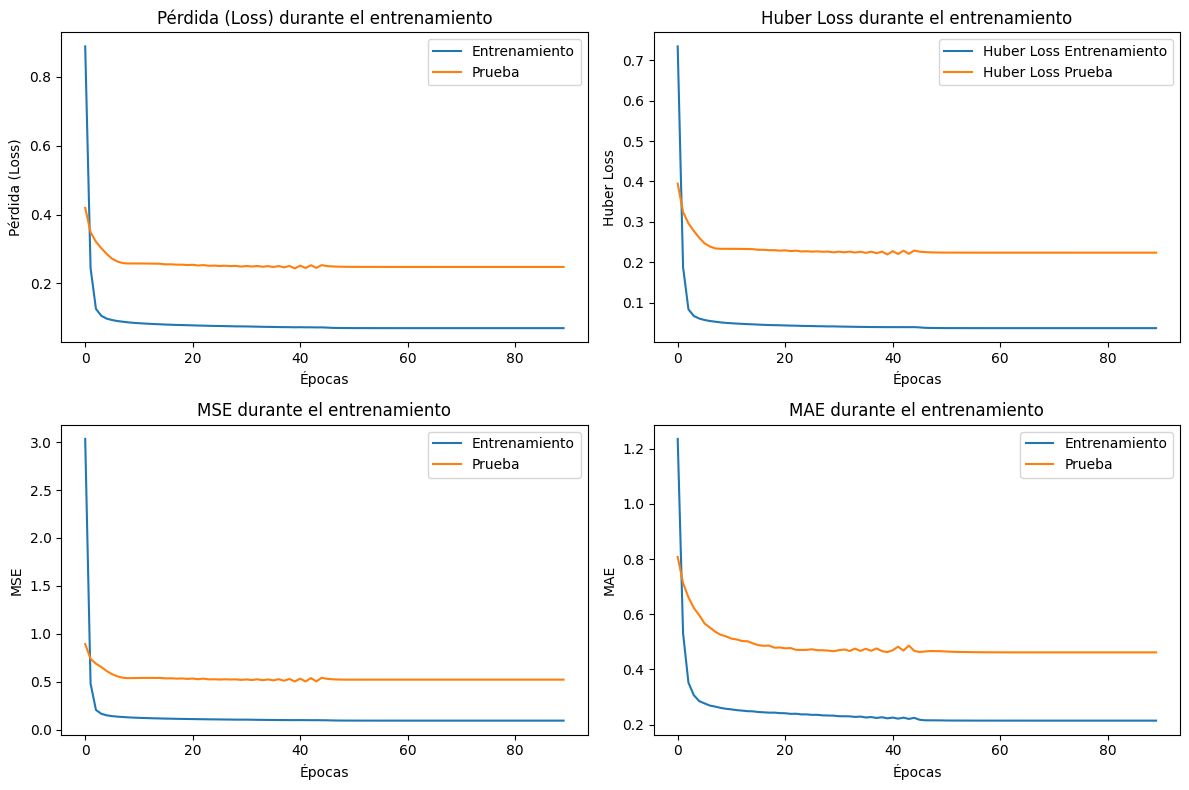

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


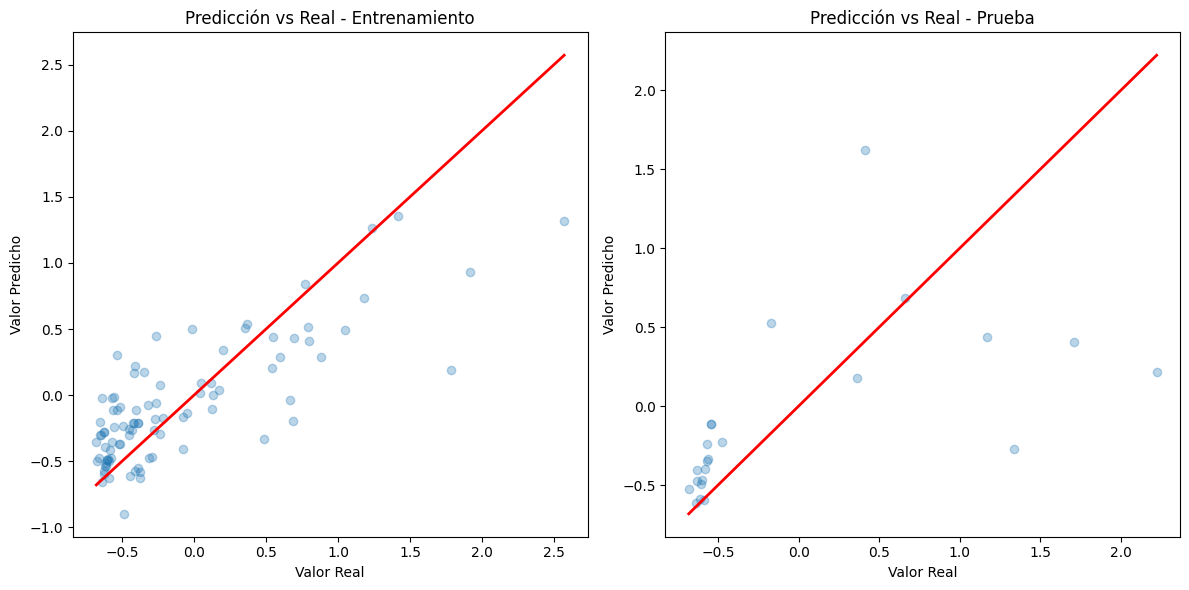

Simulación de cross_val_score (MSE): 0.26940061348149574 ± 0.13823978773133297
Simulación de cross_val_score (RMSE): 0.5026125271111992 ± 0.12954250681683532
Simulación de cross_val_score (MAE): 0.3297431383364673 ± 0.0820655213269347
SSE promedio: 398.12682963988357
SAE promedio: 325.25219695139333
R^2 promedio: 0.4376541672590828, Desviación estándar: 0.21550805280359162
Correlación de Pearson promedio: -1.5165879526110226e-16, Desviación estándar: 2.377823474686494e-16
Correlación de Spearman promedio: 0.6551869839213611, Desviación estándar: 0.16835803949493736
Huber Loss promedio: 0.07143292650580406, Desviación estándar: 0.02024615209542662
El punto de convergencia (mejor epoch): 40


In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
import numpy as np

# Definir el número de pliegues (k) para la validación cruzada
k = 5

# Crear un objeto KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Inicializar listas para almacenar las métricas en cada pliegue
mse_scores = []
mae_scores = []
sse_scores = []
sae_scores = []
r2_scores = []
pearson_scores = []
rmse_scores = []
spearman_scores = []
huber_loss_scores = []

# Iterar sobre los pliegues
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Crear y entrenar el modelo con los datos del pliegue actual
    model = Sequential([
        Dense(int(best_params['units_1']), input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('relu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(int(best_params['units_2']), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('relu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(1, activation='linear')
    ])

    # Función personalizada para calcular SSE
    def sse(y_true, y_pred):
        return tf.reduce_sum(tf.square(y_true - y_pred))

    # Función personalizada para calcular SAE
    def sae(y_true, y_pred):
        return tf.reduce_sum(tf.abs(y_true - y_pred))

    # Función personalizada para calcular el coeficiente de determinación R^2
    def r2_keras(y_true, y_pred):
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
        ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
        return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

    # Función personalizada para calcular el coeficiente de correlación de Pearson
    def pearson_correlation(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float64)  # Cast y_true to float64
        y_pred = tf.cast(y_pred, tf.float64)  # Cast y_pred to float64
        x = y_true - tf.reduce_mean(y_true)
        y = y_pred - tf.reduce_mean(y_pred)
        r_num = tf.reduce_sum(x * y)
        r_den = tf.sqrt(tf.reduce_sum(tf.square(x)) * tf.reduce_sum(tf.square(y)))
        return r_num / (r_den + tf.keras.backend.epsilon())

    model.compile(optimizer=Adagrad(best_params['learning_rate']),#------------------------------------
                  loss=tf.keras.losses.Huber(),                      #---------------------
                  metrics=['mae', 'mse', sse, sae, r2_keras, pearson_correlation, tf.keras.losses.Huber(name='huber_loss')])

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) #-----------------------50
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=1000, #--------------------------1000
                        batch_size=64,
                        callbacks=[early_stopping, reduce_lr],
                        verbose=0)

    # Predecir con el modelo en el conjunto de validación
    y_pred = model.predict(X_val)

    # Calcular las métricas de error
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    sse = np.sum((y_val - y_pred) ** 2)
    sae = np.sum(np.abs(y_val - y_pred))
    r2 = r2_score(y_val, y_pred)
    pearson = pearson_correlation(y_val, y_pred).numpy()
    spearman, _ = spearmanr(y_val, y_pred)
    huber_loss = history.history['huber_loss'][-1]

    # Almacenar las métricas en las listas
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    sse_scores.append(sse)
    sae_scores.append(sae)
    r2_scores.append(r2)
    pearson_scores.append(pearson)
    spearman_scores.append(spearman)
    huber_loss_scores.append(huber_loss)

import matplotlib.pyplot as plt

# Graficar las curvas de aprendizaje (pérdida, huber_loss, mse, mae)
plt.figure(figsize=(12, 8))

# Pérdida (Loss)
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Prueba')
plt.title('Pérdida (Loss) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()

# Huber Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['huber_loss'], label='Huber Loss Entrenamiento')
plt.plot(history.history['val_huber_loss'], label='Huber Loss Prueba')
plt.title('Huber Loss durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Huber Loss')
plt.legend()

# MSE
plt.subplot(2, 2, 3)
plt.plot(history.history['mse'], label='Entrenamiento')
plt.plot(history.history['val_mse'], label='Prueba')
plt.title('MSE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

# MAE
plt.subplot(2, 2, 4)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Prueba')
plt.title('MAE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Gráfico de predicciones en los datos de entrenamiento
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', lw=2)
plt.title('Predicción vs Real - Entrenamiento')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r', lw=2)
plt.title('Predicción vs Real - Prueba')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.tight_layout()
plt.show()

# Calcular estadísticas de las métricas
mse_mean = np.mean(mse_scores)
mse_std = np.std(mse_scores)
rmse_mean = np.mean(rmse_scores)
rmse_std = np.std(rmse_scores)
mae_mean = np.mean(mae_scores)
mae_std = np.std(mae_scores)
sse_mean = np.mean(sse_scores)
sae_mean = np.mean(sae_scores)
r2_mean = np.mean(r2_scores)
r2_std = np.std(r2_scores)
pearson_mean = np.mean(pearson_scores)
pearson_std = np.std(pearson_scores)
spearman_mean = np.mean(spearman_scores)
spearman_std = np.std(spearman_scores)
huber_loss_mean = np.mean(huber_loss_scores)
huber_loss_std = np.std(huber_loss_scores)

# Simular cross_val_score al imprimir el promedio de las métricas
print(f"Simulación de cross_val_score (MSE): {mse_mean} ± {mse_std}")
print(f"Simulación de cross_val_score (RMSE): {rmse_mean} ± {rmse_std}")
print(f"Simulación de cross_val_score (MAE): {mae_mean} ± {mae_std}")
print(f"SSE promedio: {sse_mean}")
print(f"SAE promedio: {sae_mean}")
print(f"R^2 promedio: {r2_mean}, Desviación estándar: {r2_std}")
print(f"Correlación de Pearson promedio: {pearson_mean}, Desviación estándar: {pearson_std}")
print(f"Correlación de Spearman promedio: {spearman_mean}, Desviación estándar: {spearman_std}")
print(f"Huber Loss promedio: {huber_loss_mean}, Desviación estándar: {huber_loss_std}")

# Imprimir la época en la que se alcanzó la mejor validación
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"El punto de convergencia (mejor epoch): {best_epoch}")